# Comparison of Structure Predictions Based on Data Format

In [1]:
import numpy as np
from diurnal import database, structure, train, utils, transform, visualize

In [2]:
database.download("./data/", "archiveII")
SRC = "./data/archiveII/"  # Input directory containing the CT files.
SIZE = 128  # RNA molecule maximum length (longer ones are filtered out).
DST = f"./data/archiveII_processed_{SIZE}/"  # Output directory of the formatted files.

2024-06-02T12:16:27.453407 > INFO Download and install an RNA database.
2024-06-02T12:16:27.484033 >     The dataset `archiveII` is already downloaded at `./data/archiveII`.


In [3]:
names = database.format_filenames(SRC, DST + "names.txt", SIZE)
train_names, validation_names, test_names = train.split(
    names, (0.8, 0.1, 0.1)
)

2024-06-02T12:16:29.149702 > INFO Extract the filenames from the directory `./data/archiveII/`.


7898325it [00:00, 24859561.64it/s]      



2024-06-02T12:16:29.567053 >     Detected 3975 files. Kept 2326 files.
2024-06-02T12:16:29.569631 >     The file `./data/archiveII_processed_128/names.txt` already contains the names.


In [4]:
def collapse(primary, secondary, size):
    potential_pairings = structure.Primary.to_matrix(
        primary, size, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    )
    potential_pairings = transform.linearize_half_matrix(
        potential_pairings, len(primary), N=128**2
    )
    potential_pairings = transform.collapse_linearized_matrix(
        potential_pairings
    )
    contact = structure.Secondary.to_matrix(secondary)
    contact = transform.linearize_half_matrix(contact, len(primary))
    return potential_pairings, contact

In [5]:
_, primary, secondary = utils.rna_data.read_ct_file(train_names[0])
a, b = collapse(primary, secondary, 128)

In [6]:
originals = []
compressed = []
for name in train_names:
    _, primary, secondary = utils.rna_data.read_ct_file(name)
    originals.append(len(primary))
    a, b = collapse(primary, secondary, 128)
    compressed.append(len(a))

A = np.array(originals)
B = np.array(compressed)
print(f"Min: {A.min()}    {B.min()}")
print(f"Avr: {A.mean()}    {B.mean()}")
print(f"Max: {A.max()}    {B.max()}")
rate = B / (A**2 / 2)
print(f"Min: {rate.min()}")
print(f"Avr: {rate.mean()}")
print(f"Max: {rate.max()}")

Min: 28    180
Avr: 103.03387096774193    3217.9387096774194
Max: 128    5291
Min: 0.4
Avr: 0.5808142706761906
Max: 0.652985305970612


In [7]:
def format(dst: str, names: list[str]):
    # Primary structures
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_onehot.npy",
        SIZE, structure.Primary.to_matrix
    )
    pp_scalar = lambda x, y: structure.Primary.to_matrix(
        x, y, structure.Schemes.IUPAC_PAIRINGS_SCALARS
    )
    database.format_primary_structure(
        names, f"{dst}primary_potential_pairings_scalar.npy", SIZE, pp_scalar
    )
    database.format_primary_structure(
        names, f"{dst}primary_masks.npy", SIZE, structure.Primary.to_mask
    )
    database.format_primary_structure(
        names, f"{dst}primary_onehot.npy",
        SIZE, structure.Primary.to_onehot
    )
    database.format_primary_structure(
        names, f"{dst}primary_linear.npy",
        SIZE, transform.primary_linear_formatter
    )
    database.format_primary_structure(
        names, f"{dst}primary_collapsed.npy",
        SIZE, transform.primary_linear_collapse_formatter
    )
    # Secondary structures.
    database.format_secondary_structure(
        names, f"{dst}secondary_bracket.npy", SIZE,
        structure.Secondary.to_onehot
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_contact.npy", SIZE,
        structure.Secondary.to_matrix
    )
    distance_formatter = lambda x, y: structure.Secondary.to_distance_matrix(
        x, y, power=5
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_distance.npy", SIZE, distance_formatter
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_linear.npy", SIZE,
        transform.secondary_linear_formatter
    )
    distance_formatter = lambda x, size: transform.secondary_linear_formatter(
        x, size, power=5
    )
    database.format_secondary_structure(
        names, f"{dst}secondary_linear_distance.npy", SIZE,
        transform.secondary_linear_formatter
    )
    database.format_primary_secondary_structure(
        names, f"{dst}secondary_collapsed.npy", SIZE,
        transform.secondary_linear_collapse_formatter
    )
    distance_formatter = lambda x, y, size: transform.secondary_linear_collapse_formatter(
        x, y, size, power=5
    )
    database.format_primary_secondary_structure(
        names, f"{dst}secondary_collapsed_distance.npy", SIZE,
        distance_formatter
    )

In [8]:
format(f"{DST}validation/", validation_names)
format(f"{DST}test/", test_names)
format(f"{DST}train/", train_names)

2024-06-02T12:17:18.627072 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_onehot.npy`.
2024-06-02T12:17:18.744744 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_onehot.npy` already contains the formatted data.
2024-06-02T12:17:18.746261 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy`.
2024-06-02T12:17:18.804212 >     The file `./data/archiveII_processed_128/validation/primary_potential_pairings_scalar.npy` already contains the formatted data.
2024-06-02T12:17:18.806259 > INFO Formatting primary structures into `./data/archiveII_processed_128/validation/primary_masks.npy`.
2024-06-02T12:17:18.877939 >     The file `./data/archiveII_processed_128/validation/primary_masks.npy` already contains the formatted data.
2024-06-02T12:17:18.880428 > INFO Formatting primary structures into `./data/archiveII_processed_128/

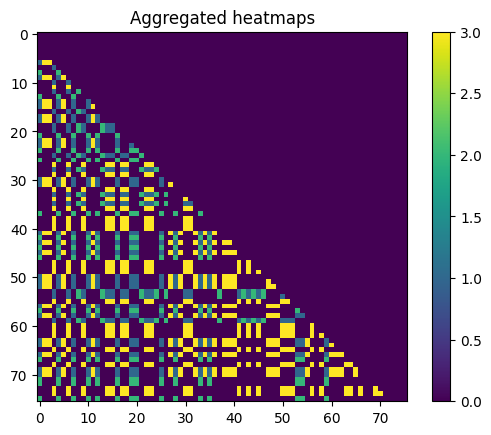

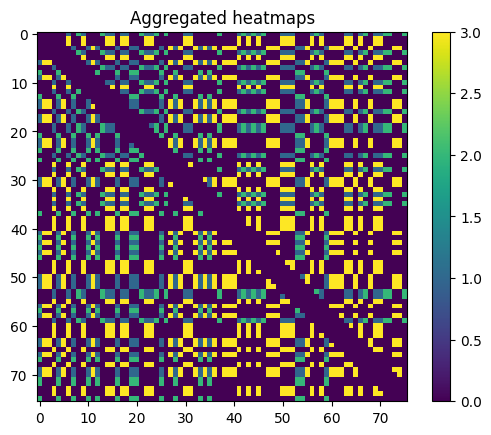

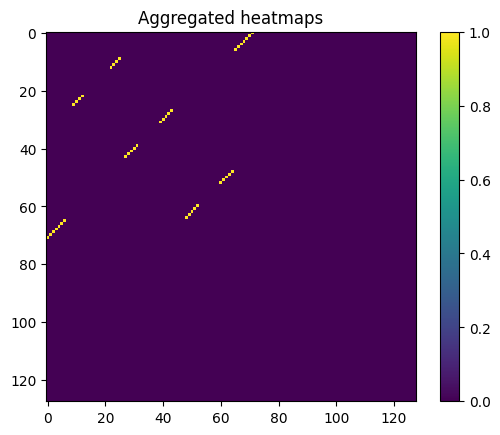

In [22]:
index = 2

primary = np.load(f"{DST}train/primary_onehot.npy")
sequence = structure.Primary.to_sequence(primary[index])
original_length = len(sequence)
collapsed_primary = np.load(f"{DST}train/primary_collapsed.npy")
potential_pairings = transform.decollapse_linearized_matrix(
    collapsed_primary[index], N_output=128**2
)
potential_pairings = transform.delinearize_half_matrix(potential_pairings, original_length)
visualize.heatmap(potential_pairings)

probe = structure.Primary.to_matrix(sequence, map=structure.Schemes.IUPAC_PAIRINGS_SCALARS)
visualize.heatmap(probe)

secondary = np.load(f"{DST}train/secondary_contact.npy")
contact = secondary[index]
visualize.heatmap(contact)

## Distance Training

In [10]:
def format_data(input, output) -> tuple:
    train_set = {
        "input": (np.load(f"{DST}train/{input}.npy"), ),
        "output": np.load(f"{DST}train/{output}.npy"),
        "contact": np.load(f"{DST}train/secondary_contact.npy"),
        "sequence": np.load(f"{DST}train/primary_onehot.npy"),
        "names": []
    }
    validation_set = {
        "input": (np.load(f"{DST}validation/{input}.npy"), ),
        "output": np.load(f"{DST}validation/{output}.npy"),
        "contact": np.load(f"{DST}validation/secondary_contact.npy"),
        "sequence": np.load(f"{DST}validation/primary_onehot.npy"),
        "names": []
    }
    test_set = {
        "input": (np.load(f"{DST}test/{input}.npy"), ),
        "output": np.load(f"{DST}test/{output}.npy"),
        "contact": np.load(f"{DST}test/secondary_contact.npy"),
        "sequence": np.load(f"{DST}test/primary_onehot.npy"),
        "names": []
    }
    return train_set, validation_set, test_set

t, v, tt = format_data(
    "primary_potential_pairings_scalar",
    "secondary_distance"
)

In [11]:
from diurnal.models import deep
from diurnal.models.deep import cnn
from torch import optim, nn

N_MAX_EPOCHS = 500
model = deep.NN(
    model=cnn.Autoencoder2D(SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-06-02T12:17:57.132729 > INFO Training the model with 1860 data points.
2024-06-02T12:17:57.136010 >     Using 232 data points for validation.
2024-06-02T12:17:57.136772 >     Beginning the training.
2024-06-02T12:18:26.905190 >   0 / 500 [                                                  ] Loss: 0.03078  Patience: 5
2024-06-02T12:18:27.416052 >   1 / 500 [                                                  ] Loss: 0.02410  Patience: 5
2024-06-02T12:18:27.876941 >   2 / 500 [                                                  ] Loss: 0.02167  Patience: 5
2024-06-02T12:18:28.360415 >   3 / 500 [                                                  ] Loss: 0.01980  Patience: 5
2024-06-02T12:18:28.830538 >   4 / 500 [                                                  ] Loss: 0.01841  Patience: 5
2024-06-02T12:18:29.345411 >   5 / 500 [                                                  ] Loss: 0.01732  Patience: 5
2024-06-02T12:18:29.877365 >   6 / 500 [                                          

In [12]:
index = 0
prediction = model.predict([tt["input"][0][index]])
distance = tt["output"][index]
true = tt["contact"][index]
sequence = tt["sequence"][index]

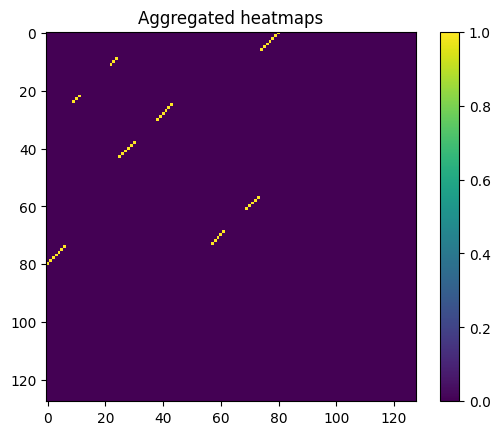

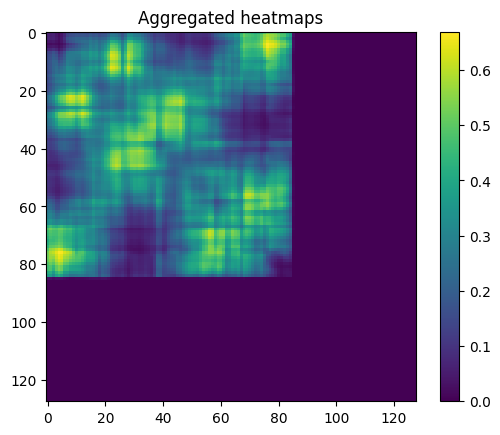

In [13]:
visualize.heatmap(true)
folded = prediction * prediction.T
visualize.heatmap(folded)

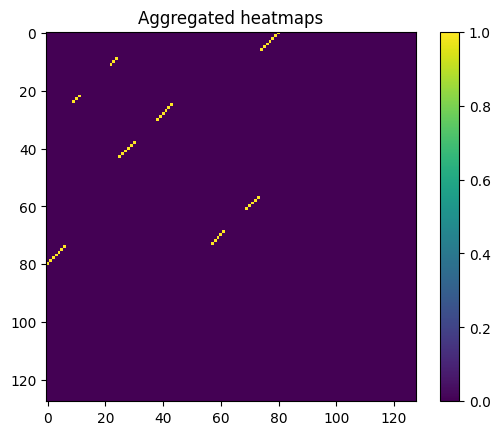

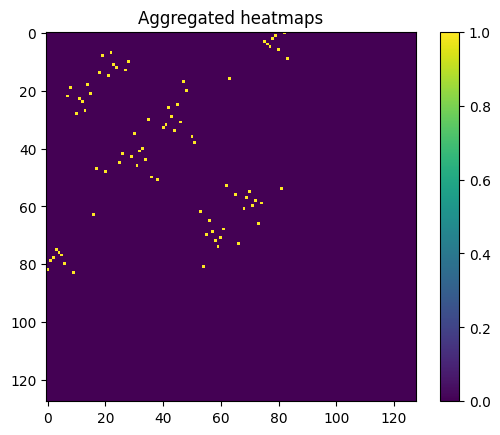

In [14]:
visualize.heatmap(true)
primary = structure.Primary.to_sequence(sequence)
mask = structure.Primary.to_mask(primary, size=128)
visualize.heatmap(transform.quantize(prediction * mask))

## Contact Training

In [15]:
t, v, tt = format_data(
    "primary_potential_pairings_scalar",
    "secondary_contact"
)

In [16]:
N_MAX_EPOCHS = 500
model = deep.NN(
    model=cnn.Autoencoder2D(SIZE),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-06-02T12:24:13.635997 > INFO Training the model with 1860 data points.
2024-06-02T12:24:13.637019 >     Using 232 data points for validation.
2024-06-02T12:24:13.639141 >     Beginning the training.
2024-06-02T12:24:14.471214 >   0 / 500 [                                                  ] Loss: 0.00357  Patience: 5
2024-06-02T12:24:14.986359 >   1 / 500 [                                                  ] Loss: 0.00357  Patience: 5
2024-06-02T12:24:15.520059 >   2 / 500 [                                                  ] Loss: 0.00357  Patience: 4
2024-06-02T12:24:16.019109 >   3 / 500 [                                                  ] Loss: 0.00357  Patience: 3
2024-06-02T12:24:16.506990 >   4 / 500 [                                                  ] Loss: 0.00357  Patience: 2
2024-06-02T12:24:16.998420 >   5 / 500 [                                                  ] Loss: 0.00357  Patience: 1



## Linear Distances Training

In [17]:
t, v, tt = format_data(
    "primary_linear",
    "secondary_linear_distance"
)

In [18]:
N_MAX_EPOCHS = 500

from torch import Tensor, stack, squeeze, nn, optim
from diurnal.models import deep
import torch.nn.functional as F

class Autoencoder1D(nn.Module):
    """Neural network used to predict a contact matrix.

    Input: 1D matrix.

    Output: 1D matrix with elements comprised within the range (0, 1).
    """
    def __init__(self, n: int):
        super().__init__()
        kernel = 3
        n2 = int(n / 2)
        n4 = int(n / 4)
        self.activation = F.relu
        self.linear1 = nn.Linear(n, n2)
        self.linear2 = nn.Linear(n2, n4)
        self.linear3 = nn.Linear(n4, n2)
        self.linear4 = nn.Linear(n4, n)
        self.output = nn.Sigmoid()

    def forward(self, y: Tensor) -> Tensor:
        """Forward propagation.

        Args:
            x: Potential pairing matrix.

        Returns: Blurry distance matrix.
        """
        x1 = stack((y, ), dim=1)
        x = self.activation(x1)
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        # x = self.linear3(x)
        # x = self.activation(x)
        x = self.linear4(x)
        x *= x1
        x = self.output(x)
        x = squeeze(x)
        return x

model = deep.NN(
    model=Autoencoder1D(int(SIZE**2/2)),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-06-02T12:24:23.637512 > INFO Training the model with 1860 data points.
2024-06-02T12:24:23.637512 >     Using 232 data points for validation.
2024-06-02T12:24:23.640379 >     Beginning the training.
2024-06-02T12:24:25.169326 >   0 / 500 [                                                  ] Loss: 0.18803  Patience: 5
2024-06-02T12:24:26.316793 >   1 / 500 [                                                  ] Loss: 0.18797  Patience: 5
2024-06-02T12:24:27.427938 >   2 / 500 [                                                  ] Loss: 0.18795  Patience: 5
2024-06-02T12:24:28.548303 >   3 / 500 [                                                  ] Loss: 0.18794  Patience: 5
2024-06-02T12:24:29.666914 >   4 / 500 [                                                  ] Loss: 0.18791  Patience: 5
2024-06-02T12:24:30.776918 >   5 / 500 [                                                  ] Loss: 0.18787  Patience: 5
2024-06-02T12:24:31.891255 >   6 / 500 [                                          

In [19]:
from torch import tensor
index = 0
prediction = model.nn(tensor([tt["input"][0][index]]).to("cuda").half()).detach().cpu().numpy()
distance = tt["output"][index]
true = tt["contact"][index]
sequence = tt["sequence"][index]

C:\Users\vince\AppData\Local\Temp\ipykernel_9548\2204607297.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  prediction = model.nn(tensor([tt["input"][0][index]]).to("cuda").half()).detach().cpu().numpy()


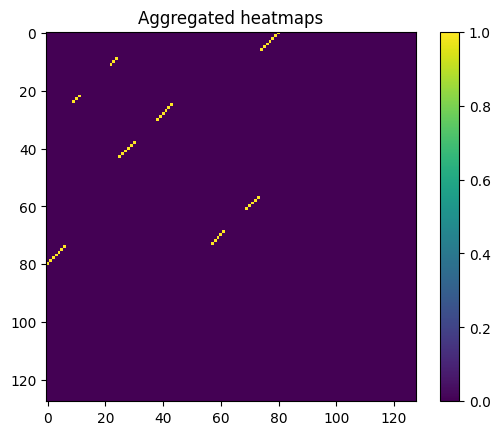

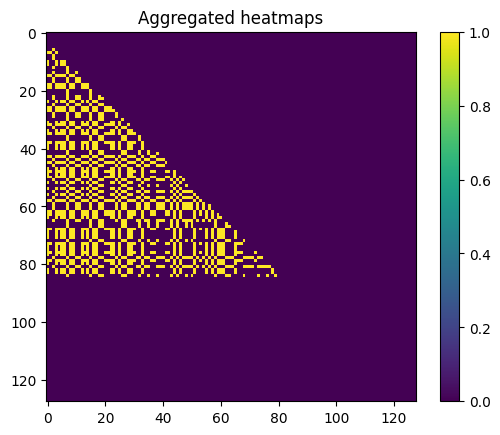

In [20]:
visualize.heatmap(true)
primary = structure.Primary.to_sequence(sequence)
half = transform.delinearize_half_matrix(prediction, len(primary), 128)
visualize.heatmap(half)

## Collapsed Distances

In [43]:
t, v, tt = format_data(
    "primary_linear",
    "secondary_collapsed"
)

In [44]:
model = deep.NN(
    model=Autoencoder1D(int(SIZE**2/2)),
    n_epochs=N_MAX_EPOCHS,
    optimizer=optim.Adam,
    loss_fn=nn.MSELoss,
    optimizer_args={"eps": 1e-4},
    loss_fn_args=None,
    use_half=True,
    patience=5,
    verbosity=2,
)
model.train(t, v)

2024-05-28T22:07:52.312084 > INFO Training the model with 1860 data points.
2024-05-28T22:07:52.314101 >     Using 232 data points for validation.
2024-05-28T22:07:52.314785 >     Beginning the training.
2024-05-28T22:07:53.664069 >   0 / 500 [                                                  ] Loss: 0.28138  Patience: 5
2024-05-28T22:07:54.778087 >   1 / 500 [                                                  ] Loss: 0.28133  Patience: 5
2024-05-28T22:07:55.897408 >   2 / 500 [                                                  ] Loss: 0.28127  Patience: 5
2024-05-28T22:07:57.047652 >   3 / 500 [                                                  ] Loss: 0.28094  Patience: 5
2024-05-28T22:07:58.165197 >   4 / 500 [                                                  ] Loss: 0.28039  Patience: 5
2024-05-28T22:07:59.364040 >   5 / 500 [                                                  ] Loss: 0.28029  Patience: 5
2024-05-28T22:08:00.493013 >   6 / 500 [                                          

## Conclusion

Oh no! Seems like transforming a 2D matrix into a linear matrix sucks.